In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from rfest import splineLG, splineLNP, splineLNLN
from rfest import build_design_matrix, get_spatial_and_temporal_filters

# Load Data

In this notebook, we use Salamander RGC data from [(Maheswaranathan et. al. 2018)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006291). You can download it [here](https://github.com/baccuslab/inferring-hidden-structure-retinal-circuits/blob/master/rgc_whitenoise.h5).

In [2]:
datapath = '../../../data/rgc_whitenoise.h5' # change this to where you save the file
with h5py.File(datapath, 'r') as f:
    print(f.keys())
    stimulus = np.array(f['stimulus'])
    rates = np.array(f['firing_rates'])
    spikes = np.array(f['spike_counts'])
    time = np.array(f['time'])

<KeysViewHDF5 ['firing_rates', 'spike_counts', 'stimulus', 'time']>


In [3]:
stim_dim = stimulus.shape[0]
hist_dim = 40
dims = [hist_dim, stim_dim]

dt = 0.01
R = 1

cell_id = 7

X = build_design_matrix(stimulus.T, dims[0])
y_spike = spikes[cell_id]
y_rate = rates[cell_id]

df = np.round((np.array(dims) / dims[0]) * 21).astype(int)
# df = np.round((np.array(dims) / dims[0]) * 17).astype(int)

# Linear-Gaussian Model

Initialzing `splineLG` and others, STA (`w_sta`) and spline-based maximum likelihood (`w_spl`) will be calculated automatically. Calculating MLE (`w_mle`) is optional, as it is unpractical to do everytime for large dataset. By calling `fit()`, the optimized RF (`w_opt`) is computed with regularization, where flag `alpha` is the balance between L1 and L2, flag `beta` is the overall penalty weight.

In [4]:
lg = splineLG(X, y_rate, dims=dims, df=df, compute_mle=True)
lg.fit(num_iters=100, beta=0.5, verbal=30)

/Users/ziweih/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Iter	Cost	
0	292.203	
30	290.604	
60	290.550	
90	290.546	
Stop: reached 100 steps, final cost=290.54198.


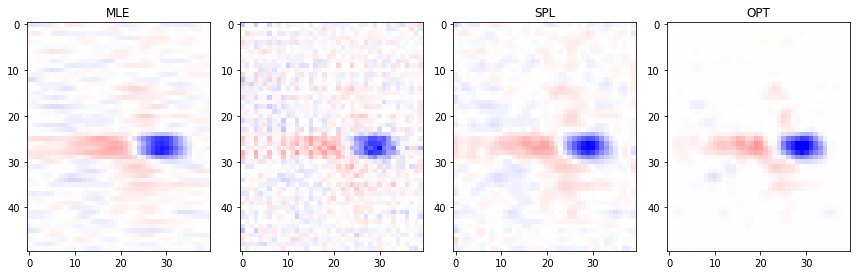

In [5]:
def plot_single_filter(obj, vmin=-0.2, vmax=0.2):
    
    def norm(x):
        return x / np.linalg.norm(x)
    
    dims = obj.dims
    sta = norm(obj.w_sta).reshape(dims).T
    spl = norm(obj.w_spl).reshape(dims).T
    try:
        mle = norm(obj.w_mle).reshape(dims).T
    except:
        mle = np.zeros_like(sta)
    try:
        opt = norm(obj.w_opt).reshape(dims).T
    except:
        opt = np.zeros_like(sta)
    
    fig, ax = plt.subplots(1, 4, figsize=(12, 4))
    ax[0].imshow(sta, cmap=plt.cm.bwr, vmin=vmin, vmax=vmax)
    ax[0].set_title('STA')
    
    ax[1].imshow(mle, cmap=plt.cm.bwr, vmin=vmin, vmax=vmax)

    if (mle == 0).all():
        ax[1].axis('off')
        ax[1].set_title('MLE (not computed)')
    else:
        ax[0].set_title('MLE')
        
    ax[2].imshow(spl, cmap=plt.cm.bwr, vmin=vmin, vmax=vmax)
    ax[2].set_title('SPL')
    
    ax[3].imshow(opt, cmap=plt.cm.bwr, vmin=vmin, vmax=vmax)

    if (opt == 0).all():
        ax[3].axis('off')
        ax[3].set_title('OPT (not computed)')
    else:
        ax[3].set_title('OPT')

    fig.tight_layout()

plot_single_filter(lg)

# Linear-Nonlinear Poisson Model

`splineLNP` has a few extra arguments. `dt` is the refresh rate of the stimulus, `R` is the maximum firing rate. The default of nonlinearity is `softplus`, as it's more stabler than `exponential` most of the time. If a flexible nonlinearity is desired, nonlinearity can be set to `nonparametric` then followed by calling `fit_nonlinearity()`

In [6]:
lnp = splineLNP(X, y_spike, dims=dims, df=df, dt=dt, R=y_spike.max(), compute_mle=True,
                nonlinearity='nonparametric')
lnp.fit_nonlinearity(w='w_spl') # w can be 'w_sta' or 'w_spl', or an already-computed RF.
lnp.fit(num_iters=100, beta=150, verbal=30) # as the cost function is not normalized
                                             # by the sample size, the good choice of lambd 
                                             # will vary from dataset to dataset. 

Iter	Cost	
0	-3348.570	
30	-10482.658	
60	-10660.329	
90	-10666.201	
Stop: reached 100 steps, final cost=-10666.20211.


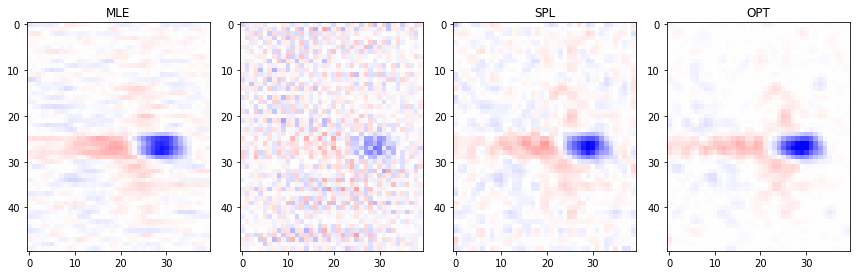

In [7]:
plot_single_filter(lnp)

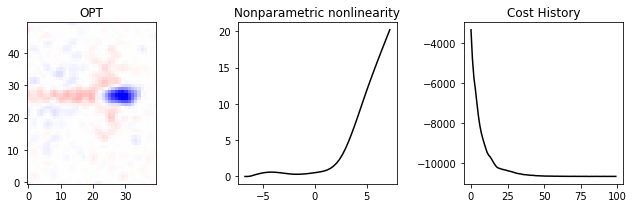

In [8]:
def plot_results(obj):
    k = obj.w_opt
    k_norm = ( k/ np.linalg.norm(k)).reshape(dims)

    fig, ax = plt.subplots(1,3, figsize=(9,3))
    ax[0].imshow(k_norm.T, origin='lower', cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
    ax[0].set_title('OPT')

    ax[1].plot(obj.bins, obj.nonlin(obj.bins, nl='nonparametric'), color='black')
    ax[1].set_title('Nonparametric nonlinearity')

    ax[2].plot(obj.cost_history, color='black')
    ax[2].set_title('Cost History')


    fig.tight_layout()
    
plot_results(lnp)

# Subunit Model

For estimating subunits, it'd be a good idea to do a spike-triggered covariance analysis first, so that we will have a rough idea of how many subunits to estimate (let's say it's a lower bound), and can fit a flexible nonlinearity using STC filters. 

In [9]:
lnln = splineLNLN(X, y_spike, dims=dims, df=df, dt=dt, R=y_spike.max(), 
                 filter_nonlinearity='nonparametric', output_nonlinearity='softplus')
lnln.STC(n_repeats=10, verbal=1)

STC significance test: 
  1/10
  2/10
  3/10
  4/10
  5/10
  6/10
  7/10
  8/10
  9/10
  10/10
 Done.


Number of excitatory filters 32
Number of supressive filters 2


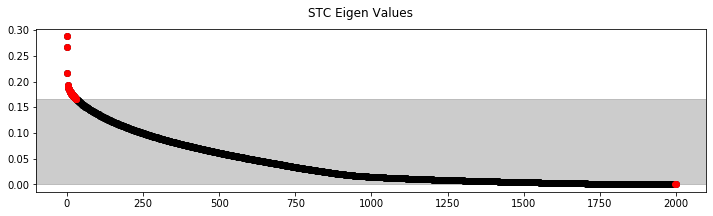

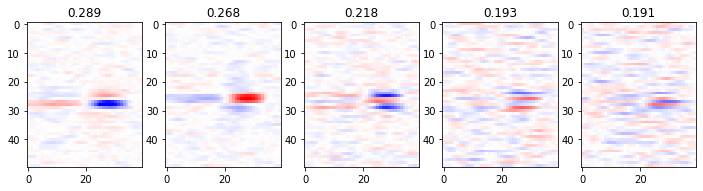

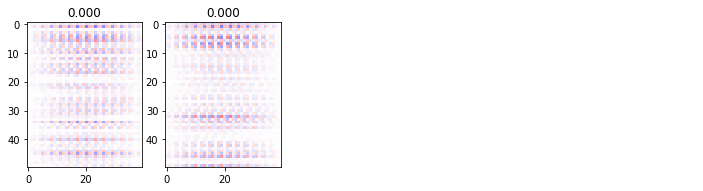

In [10]:
def plot_STC(obj, vmin=-0.2, vmax=0.2):
    
    def norm(x):
        return x / np.linalg.norm(x)
    
    dims = obj.dims
    
    fig, ax = plt.subplots(figsize=(12,3))
    xx = np.arange(len(obj.w_stc_eigval))
    ax.plot(xx, obj.w_stc_eigval, 'ko')
    
    fig.suptitle('STC Eigen Values')
    
    if hasattr(obj, 'w_stc_pos'):
    
        mask = obj.w_stc_eigval_mask
        ax.plot(xx[mask], obj.w_stc_eigval[mask], 'ro')    
        ax.axhspan(obj.w_stc_min_null, obj.w_stc_max_null, color='grey', alpha=0.4)

        n_pos = obj.w_stc_pos.shape[1]
        n_neg = obj.w_stc_neg.shape[1]
        print(f'Number of excitatory filters {n_pos}')
        print(f'Number of supressive filters {n_neg}')

    
        if n_pos:
            fig, ax = plt.subplots(1, 5, figsize=(12, 3))
            for i in range(n_pos)[:5]:
                w = norm(obj.w_stc_pos[:, i].reshape(dims)).T
                eigval = obj.w_stc_eigval[obj.w_stc_eigval_pos_mask][i]
                ax[i].imshow(w, cmap=plt.cm.bwr, vmin=vmin, vmax=vmax)
                ax[i].set_title(f'{eigval:.03f}')
            else:
                for j in range(i+1, 5):
                    ax[j].axis('off')
                    
        if n_neg:
            fig, ax = plt.subplots(1, 5, figsize=(12, 3))
            for i in range(n_neg)[:5]:
                eigval = obj.w_stc_eigval[obj.w_stc_eigval_neg_mask][i]
                w = norm(obj.w_stc_neg[:, i].reshape(dims)).T
                ax[i].imshow(w, cmap=plt.cm.bwr, vmin=vmin, vmax=vmax)
                ax[i].set_title(f'{eigval:.03f}')
            else:
                for j in range(i+1, 5):
                    ax[j].axis('off')                
        
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12, 3))
        for i in range(5):
            w = norm(obj.w_stc[:, i].reshape(dims)).T
            eigval = obj.w_stc_eigval[i]
            ax[i].imshow(w, cmap=plt.cm.bwr, vmin=vmin, vmax=vmax)
            ax[i].set_title(f'{eigval:.03f}')
        
        fig, ax = plt.subplots(1, 5, figsize=(12, 3))
        for i in range(5):
            w = norm(obj.w_stc[:, -i-1].reshape(dims)).T
            eigval = obj.w_stc_eigval[-i-1]
            ax[i].imshow(w, cmap=plt.cm.bwr, vmin=vmin, vmax=vmax)
            ax[i].set_title(f'{eigval:.03f}')
    
plot_STC(lnln)

In [11]:
lnln.fit_nonlinearity(w='w_spl')
lnln.fit(num_iters=300, num_subunits=4, beta=10, verbal=30)

Iter	Cost	
0	-2589.995	
30	-5018.561	
60	-5084.754	
90	-5089.372	
120	-5089.297	
150	-5088.636	
180	-5088.057	
210	-5087.734	
240	-5087.554	
270	-5087.026	
Stop: reached 300 steps, final cost=-5086.88567.


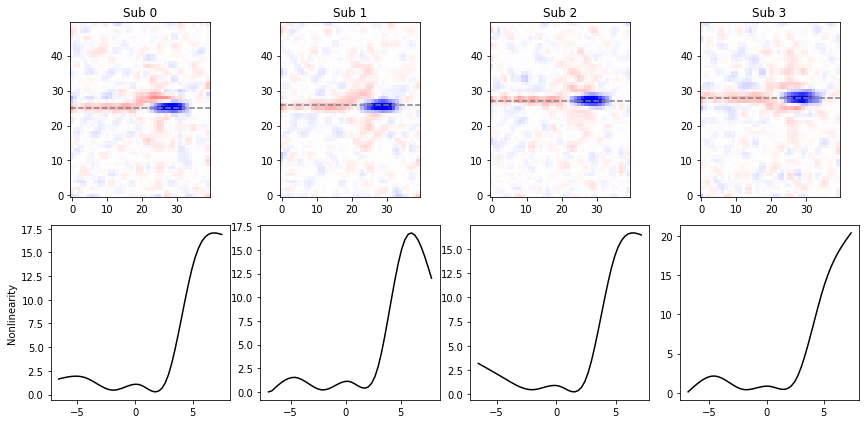

In [12]:
def plot_results(obj):
    
    sRF_min = []
    for i in range(4):
        sRF, tRF = get_spatial_and_temporal_filters(obj.w_opt[:, i], dims)
        sRF_min.append(sRF.argmin())
        
    sRF_order = np.argsort(sRF_min)
    
    w_opt = obj.w_opt[:, sRF_order]
    sRF_min = np.array(sRF_min)[sRF_order]

    fig, ax = plt.subplots(2,4, figsize=(12,6))
    
    for i in range(4):
        k = w_opt[:, i]
        k_norm = ( k/ np.linalg.norm(k)).reshape(dims)
        ax[0, i].imshow(k_norm.T, origin='lower', cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
        ax[0, i].set_title(f'Sub {i}')
        ax[0, i].axhline(sRF_min[i], color='grey', linestyle='--')
        
        obj.fit_nonlinearity(w=w_opt[:, i])
        ax[1, i].plot(obj.bins, obj.nonlin(obj.bins, nl='nonparametric'), color='black')
    ax[1, 0].set_ylabel('Nonlinearity')

    fig.tight_layout()
    
plot_results(lnln)